# L3: Custom Components - News Summarizer

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Custom Component Requirements
#### Build a Custom Component


In [3]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

#### Run the Component

In [4]:
greeter = Greeter()

greeter.run(user_name="Tuana")

{'greeting': 'Hello Tuana'}

#### Add the Component to a Pipeline

In [18]:
greeter = Greeter()
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""
prompt = PromptBuilder(template=template)
llm = OpenAIGenerator()

dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

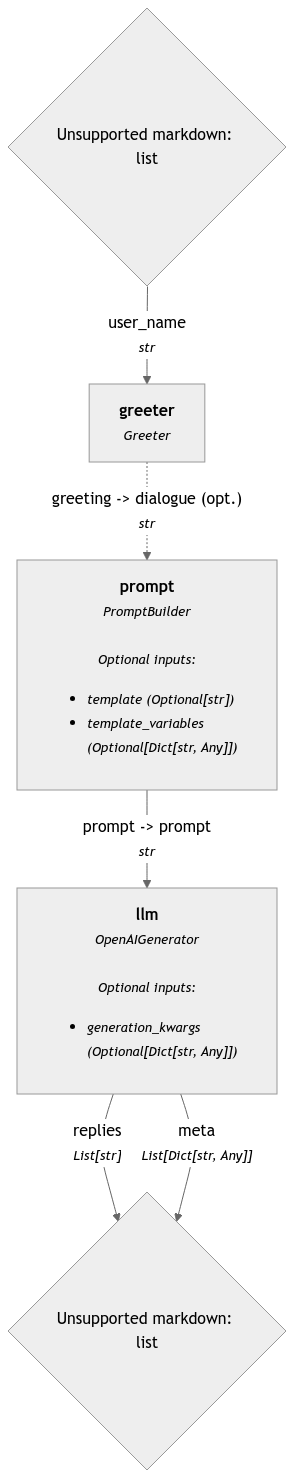

In [19]:
dialogue_builder.show()

In [20]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Tuana"}})

print(dialogue["llm"]["replies"][0])

Characters: Emily and Tuana

(Emily enters the room where Tuana is seated)

Emily: Hello Tuana. How are you doing today?

Tuana: Oh, hello Emily. I'm feeling a bit tired, to be honest. Long day at work.

Emily: I hear you. It's been a busy week for me too. But, hey, at least it's almost the weekend, right?

Tuana: Definitely looking forward to that. Any exciting plans for the weekend?

Emily: Not really, just hoping to catch up on some much-needed rest. How about you?

Tuana: I might go hiking with some friends, if the weather holds up. Need to get out and enjoy the fresh air.

Emily: Sounds fun! I wish I were more outdoorsy like you. Maybe I'll join next time.

Tuana: You should! It's always a good time. Anyways, how about we grab some lunch? I'm starving.

Emily: Sounds like a plan. Let's go find something yummy to eat.

(They both exit the room together and the scene fades out) 

- End of Script -


## Build a Hacker News Summarizer

> **Note:** Everyone will get different results for this application to what you see in the recording. Results depend on when you run it as it's based on 'current' top/new posts on Hacker News. 

In [21]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'notmine1337', 'descendants': 90, 'id': 41510252, 'kids': [41511310, 41510461, 41510544, 41510651, 41511245, 41511677, 41511349, 41510451, 41510538, 41510537, 41510631, 41511525, 41511147, 41510703, 41510579, 41510823, 41510469, 41510553, 41511287, 41510602, 41510922], 'score': 431, 'time': 1726053552, 'title': 'We spent $20 to achieve RCE and accidentally became the admins of .mobi', 'type': 'story', 'url': 'https://labs.watchtowr.com/we-spent-20-to-achieve-rce-and-accidentally-became-the-admins-of-mobi/'}


In [22]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [23]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline
        
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [24]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=e8cba024aca0fe1a367d26bde4bf49232728463fe56e2326eea7c529b79a344c, content: 'We Spent $20 To Achieve RCE And Accidentally Became The Admins Of .MOBI
Welcome back to another watc...', meta: {'content_type': 'text/html', 'url': 'https://labs.watchtowr.com/we-spent-20-to-achieve-rce-and-accidentally-became-the-admins-of-mobi/'}), Document(id=cdb7c9125bd9a0441cd36f22f56b73d9b6b3efff6ce7558ba2d87a224e65e416, content: 'Max Headroom and the Strange World of Pseudo-CGI
I’ve come across people who believe that Max Headro...', meta: {'content_type': 'text/html', 'url': 'https://www.cartoonbrew.com/cgi/max-headroom-and-the-strange-world-of-pseudo-cgi-82745.html'}), Document(id=3b99751798a551dc4ab96090d129f4a98de384ac7bfbc6f1bfac35a68500be4a, content: 'Building a browser using Servo as a web engine!
2024-09-11 Let's build another web browser based on ...', meta: {'content_type': 'text/html', 'url': 'https://servo.org/blog/2024/09/11/building-browser/'})]


In [25]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

In [26]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

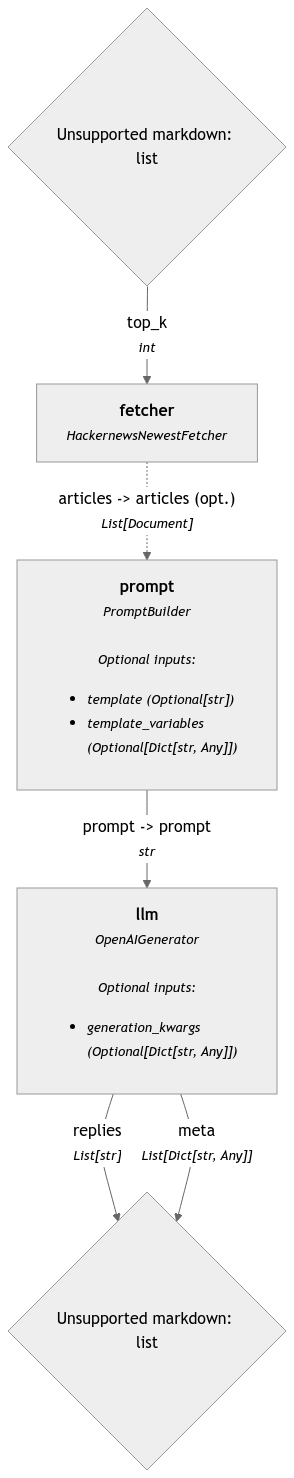

In [27]:
summarizer_pipeline.show()

In [28]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

Summary
The posts discuss different topics related to technology:

1. The first post discusses a discovery by watchTowr Labs where, by acquiring an expired WHOIS server domain, they inadvertently became the administrators of the .MOBI TLD. This allowed them to undermine the TLS/SSL certificate authority process and highlighted security vulnerabilities. The post also dives into technical details and prior art related to exploiting WHOIS client vulnerabilities.

2. The second post explores the creation of the character Max Headroom in the 1980s, using techniques to simulate computer animation before CGI became widespread. It reflects on the creativity and charm of analog animation techniques and how they can inspire modern digital animators.

3. The third post dives into the development of a web browser using Servo as the web engine. It discusses the implementation of multi-view and multi-window support, as well as plans for benchmarking, script triage, and improvements in multi-process 

In [29]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [30]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

Summary: The post discusses the concept of pseudo-CGI animation, citing examples from the Eighties such as Max Headroom and Escape from New York, where computer animation was simulated using practical effects and digital trickery. The post reflects on the creativity and charm of these techniques compared to modern computer-generated imagery.

URL: https://www.cartoonbrew.com/cgi/max-headroom-and-the-strange-world-of-pseudo-cgi-82745.html


### Extra resources! 

Learn more about the Haystack integrations:

* [deepset-ai github repo](https://github.com/deepset-ai/haystack-integrations)
* [haystack.deepset.ai/integrations](https://haystack.deepset.ai/integrations)